In [1]:
import time
import numpy as np
import pandas as pd
import pylab as plt
import matplotlib.pyplot as ptr
import enum
from scipy.integrate import odeint
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

class InfectionMultiscaleModel(Model):
    """A model for infection spread."""

    def __init__(self, N=10, width=10, height=10, ptrans=0.5,
                 death_rate=0.02, recovery_days=21,
                 recovery_sd=7, v_threshold=300000, G='constant'):

        self.num_agents = N
        self.recovery_days = recovery_days
        self.recovery_sd = recovery_sd
        self.ptrans = ptrans
        self.v_threshold = v_threshold
        self.death_rate = death_rate
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True
        self.dead_agents = []
        self.G = G
        self.rep = []
        self.r0 = 0
        self.init_vs = []
        self.avg_init_v = 0
        self.cellmates = []
        self.avg_cellmates = 0
        
        # Create agents
        for i in range(self.num_agents):
            a = MSMyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            #make one agent infected at start
#             infected = np.random.choice([0,1], p=[0.98,0.02])
            if i == 1:
                a.state = MSState.INFECTED
                a.recovery_time = self.get_recovery_time()
                a.infection_course = a.infect_TIV('constant',1)
#                 print(a.infection_course[2])

        self.datacollector = DataCollector(
            model_reporters={"r0" : "r0",
                            "init_v" : "avg_init_v",
                            "cellmates" : "avg_cellmates"},
            agent_reporters={"State": "state"})

    def get_recovery_time(self):
#         return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))
        return self.recovery_days

    def get_r0(self):
        if self.rep:
            return np.mean(self.rep)
        else:
            return 0
        
    def get_cellmates(self):
        if self.cellmates:
            return np.mean(self.cellmates)
        else:
            return 0
        
    def get_init_v(self):
        if self.init_vs:
            return np.mean(self.init_vs)
        else:
            return 0

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.r0 = self.get_r0()
        self.avg_init_v = self.get_init_v()
        self.avg_cellmates = self.get_cellmates()

class MSState(enum.IntEnum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    REMOVED = 2

def differential_TIV(n_TIV, t, alpha, beta, prod, clear):
    dT_dt = -1 * alpha * n_TIV[0] * n_TIV[2]
    dI_dt = alpha * n_TIV[0] * n_TIV[2] - beta * n_TIV[1]
    dV_dt = prod * n_TIV[1] - clear * n_TIV[2]
    return dT_dt, dI_dt, dV_dt
    
class MSMyAgent(Agent):
    """ An agent in an epidemic model."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)      
        self.state = MSState.SUSCEPTIBLE  
        self.infection_time = 0
        self.infection_course = []
        self.no_infected = 0
        
    def infect_TIV(self, G, donor):
        t = np.linspace(0, 12, num=60)
        y0 = ()
        alpha = 0.0000022
        beta = 1.9
        prod = 1.2
        clear = 2.78
        
        if G == 'constant':
            init_v = 10000
        elif G == 'random':
            init_v = self.random.randint(1,3000000)
        elif G == 'bottleneck':
            init_v = np.minimum(1, donor * 0.000001)
        elif G == 'linear':
            init_v = donor
        elif G == 'log':
            init_v = np.log(donor)
        elif G == 'sigmoid':
            init_v = 3700000 * np.power(donor,10) / (np.power(donor,10) + 1850000)

        self.model.init_vs.append(init_v)
            
        y0 = (25000000, 0, init_v)
        
        solution = odeint(differential_TIV, y0, t, args=(alpha, beta, prod, clear))
        solution = [[row[i] for row in solution] for i in range(3)]

        return solution

    def move(self):
        """Move the agent"""

        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def status(self):
        """Check infection status"""
        

        if self.state == MSState.INFECTED: 
            
            t = self.model.schedule.time-self.infection_time
            
#             if t >= self.recovery_time:          
#                 self.state = MSState.REMOVED
#                 self.model.rep.append(self.no_infected)

            if self.infection_course[2][t] < 1:
                self.state = MSState.REMOVED
                self.model.rep.append(self.no_infected)


    def contact(self):
        """Find close contacts and infect"""

        cellmates = self.model.grid.get_cell_list_contents([self.pos]) 
        t = self.model.schedule.time-self.infection_time
        
        self.model.cellmates.append(len(cellmates))
        
        if len(cellmates) > 1 and t>0:
            
            for other in cellmates:
#                 if self.random.random() > model.ptrans:
#                     continue
                
                if self.state is MSState.INFECTED and other.state is MSState.SUSCEPTIBLE and self.infection_course[2][t] > model.v_threshold:                    
                    other.state = MSState.INFECTED
                    other.infection_time = self.model.schedule.time
                    other.recovery_time = model.get_recovery_time()
                    other.infection_course = other.infect_TIV(model.G,self.infection_course[2][t])
                    self.no_infected += 1
                    
                   
                
    def step(self):
        self.status()
        self.move()
        self.contact()


steps = 200
pop = 2500
no_sims = 5


# print(data)
ptr.close("all")

plot1 = ptr.figure()

data_whole = pd.DataFrame()

def get_column_data(model):
    """pivot the model dataframe to get states count at each step"""
    agent_state = model.datacollector.get_agent_vars_dataframe()
    model_state = model.datacollector.get_model_vars_dataframe()
    X = pd.pivot_table(agent_state.reset_index(),index='Step',columns='State',aggfunc=np.size,fill_value=0)    
    X['r0'] = model_state['r0']
    X['init_v'] = model_state['init_v']
    X['cellmates'] = model_state['cellmates']
    labels = ['Susceptible','Infected','Removed','R0','Mean Initial Viral Load','Cellmates']
    X.columns = labels[:len(X.columns)]
    return X

for i in range(no_sims):
    print("Sim: " + str(i))
    model = InfectionMultiscaleModel(pop, 50, 50, ptrans=0.7, v_threshold=100,G='constant')
    for i in range(steps):
        model.step()

    data = get_column_data(model)
    if i==1:
        data_whole = data
    else:
        data_whole = data_whole.append(data)
        
# data_whole.plot()


Sim: 0
Sim: 1
Sim: 2
Sim: 3
Sim: 4


<Figure size 432x288 with 0 Axes>

      Susceptible  Infected  Removed      R0  Mean Initial Viral Load  \
Step                                                                    
0            2499         1        0  0.0000                      0.0   
1            2499         1        0  0.0000                  10000.0   
2            2499         1        0  0.0000                  10000.0   
3            2496         4        0  0.0000                  10000.0   
4            2494         6        0  0.0000                  10000.0   
...           ...       ...      ...     ...                      ...   
195             0         0     2500  0.9996                  10000.0   
196             0         0     2500  0.9996                  10000.0   
197             0         0     2500  0.9996                  10000.0   
198             0         0     2500  0.9996                  10000.0   
199             0         0     2500  0.9996                  10000.0   

      Cellmates  
Step             
0      0.00000

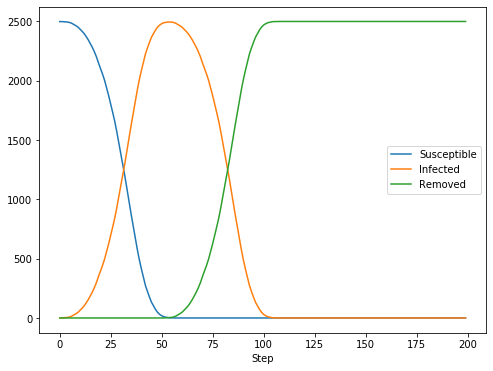

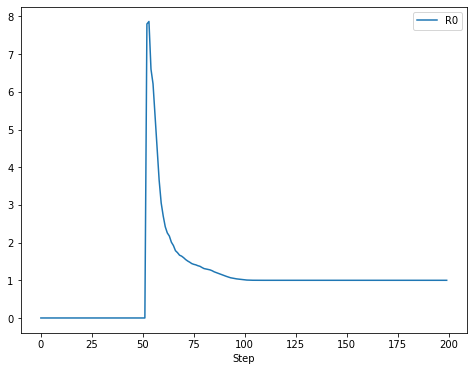

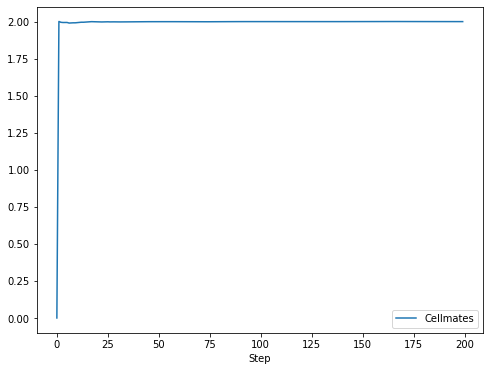

In [2]:
# ptr.figure(figsize=(10,10), dpi=100)
# axes = ptr.subplot(311)
print(data_whole)
# print(data_whole.groupby(level=0).mean())
# for i in range(no_sims):
#     low = i * steps
#     high = (i+1) * steps
#     data_whole[low:high].plot(ax=axes, y=['Susceptible','Infected','Removed'], color="blue")
# data_whole.plot(y=['Susceptible','Infected','Removed'],figsize=(8,6))
data_whole.groupby(level=0).mean().plot(y=['Susceptible','Infected','Removed'],figsize=(8,6))
data_whole.groupby(level=0).mean().plot(y="R0",figsize=(8,6))
# data_whole.groupby(level=0).mean().plot(y="Mean Initial Viral Load",figsize=(8,6))
data_whole.groupby(level=0).mean().plot(y="Cellmates",figsize=(8,6))
# ptr.show()

In [79]:
for i in range(no_sims):
    print("Sim: " + str(i))
    model = InfectionMultiscaleModel(pop, 50, 50, ptrans=0.7, v_threshold=100,G='constant',con_init=1)
    for i in range(steps):
        model.step()

    data = get_column_data(model)
    if i==1:
        data_whole = data
    else:
        data_whole = data_whole.append(data)

Step
0       0
1       0
2       0
3       0
4       0
       ..
195    27
196    27
197    27
198    27
199    27
Name: Removed, Length: 200, dtype: int64

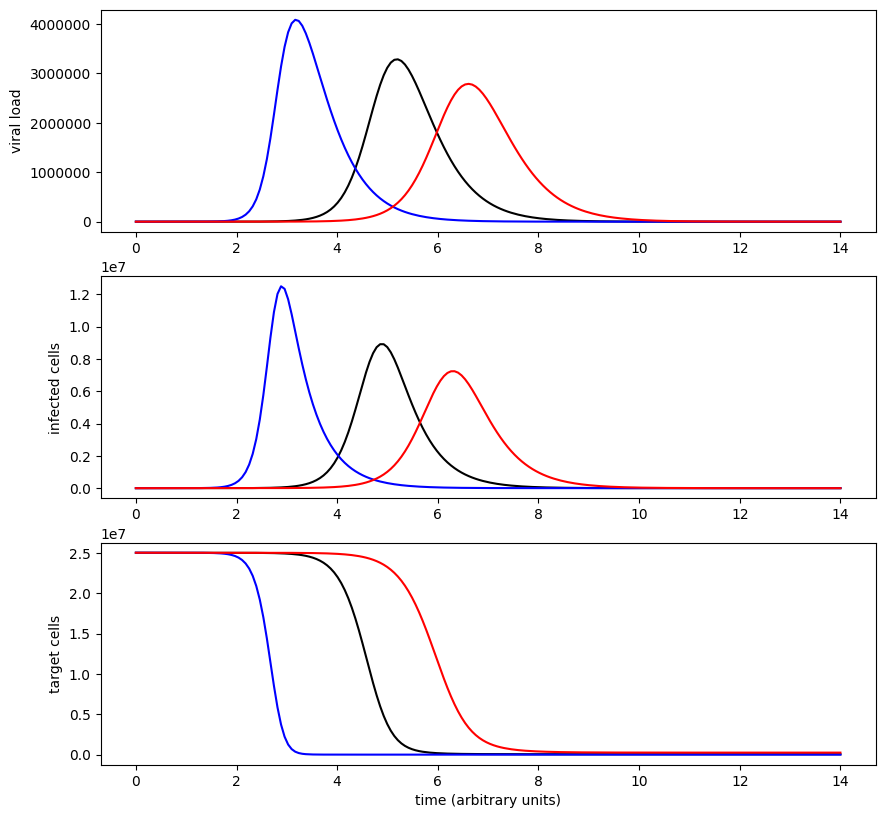

In [44]:
from matplotlib import pyplot
from numpy import linspace
from scipy.integrate import odeint
from math import log
import random


# make a nice, big figure
pyplot.figure(figsize=(10,10), dpi=100)

initital_conditions = {
    "t": [25000000],
    "i": [0],
    "v": [1],
    "time": [0.0],
}

# make a subplot for the susceptible, infected and recovered individuals
axes_s = pyplot.subplot(311)
axes_s.set_ylabel("viral load")

axes_i = pyplot.subplot(312)
axes_i.set_ylabel("infected cells")

axes_r = pyplot.subplot(313)
axes_r.set_ylabel("target cells")
axes_r.set_xlabel("time (arbitrary units)")

t = linspace(0, 14, num=200)
y0 = (25000000, 0, 1)
y1 = (25000000, 0, 1000)
y2 = (25000000, 0, 100000)
alpha = 0.0000011
alpha2 = 0.0000022
alpha3 = 0.00000082
beta = 1.9
prod = 1.2
clear = 2.78

def differential_TIV(n_TIV, t, alpha, beta, prod, clear):
    dT_dt = -1 * alpha * n_TIV[0] * n_TIV[2]
    dI_dt = alpha * n_TIV[0] * n_TIV[2] - beta * n_TIV[1]
    dV_dt = prod * n_TIV[1] - clear * n_TIV[2]
    return dT_dt, dI_dt, dV_dt

solution = odeint(differential_TIV, y0, t, args=(alpha, beta, prod, clear))
solution = [[row[i] for row in solution] for i in range(3)]

solution2 = odeint(differential_TIV, y0, t, args=(alpha2, beta, prod, clear))
solution2 = [[row[i] for row in solution2] for i in range(3)]

solution3 = odeint(differential_TIV, y0, t, args=(alpha3, beta, prod, clear))
solution3 = [[row[i] for row in solution3] for i in range(3)]

# plot numerical solution
axes_r.plot(t, solution[0], color="black")
axes_i.plot(t, solution[1], color="black")
axes_s.plot(t, solution[2], color="black")

axes_r.plot(t, solution2[0], color="blue")
axes_i.plot(t, solution2[1], color="blue")
axes_s.plot(t, solution2[2], color="blue")

axes_r.plot(t, solution3[0], color="red")
axes_i.plot(t, solution3[1], color="red")
axes_s.plot(t, solution3[2], color="red")

pyplot.show()
